<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-data,-cleaning-and-visualizing" data-toc-modified-id="Import-data,-cleaning-and-visualizing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import data, cleaning and visualizing</a></span><ul class="toc-item"><li><span><a href="#Importing-and-selecting-the-data" data-toc-modified-id="Importing-and-selecting-the-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing and selecting the data</a></span></li><li><span><a href="#Visualizing" data-toc-modified-id="Visualizing-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Visualizing</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></div>

# CC Week 18' - Restaurants Reviews SESSION 2

The goal of this subject is to build a classifier from Yelp, zomato and other sources of reviews, mapping each review to a score for food, place and ambience.
The dataset we have countains around 85 000 reviews of New York restaurants, with a global rating from 1 to 5

In [37]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn import preprocessing
import string
import gensim
from gensim import corpora
from gensim.models import phrases, Phrases, coherencemodel
from nltk import word_tokenize
from tqdm import tqdm # for progress bar
from tqdm import tqdm_notebook
tqdm.pandas(desc='progress-bar')
tqdm_notebook().pandas()
import langdetect # to detect language
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

## Import data, cleaning and visualizing

### Importing and selecting the data

First step, we import the dataset

In [61]:
restaurants_ny = pd.read_csv('restaurants_ny.csv')

In [62]:
restaurants_ny.head()

,address,name,review,stars
0,386 Flatbush Ave,Junior’s Restaurant,I've been coming to Juniors since I was a smal...,5.0
1,386 Flatbush Ave,Junior’s Restaurant,I like this place! I was initially hesitant be...,5.0
2,386 Flatbush Ave,Junior’s Restaurant,**Initial 3 star review dropped down to 1. Hop...,1.0
3,386 Flatbush Ave,Junior’s Restaurant,This was a tough one for me to voluntarily com...,4.0
4,386 Flatbush Ave,Junior’s Restaurant,"What a gem! If your hungry, want some reliable...",5.0


In [63]:
# scrapping on zomato gives us half stars
restaurants_ny['stars'] = restaurants_ny['stars'].progress_apply(round)

In [64]:
print('Number of unique restaurants: ', restaurants_ny.name.nunique())

Number of unique restaurants:  5199


In [65]:
print('Number of reviews: ', restaurants_ny.shape[0])

Number of reviews:  84045


Now, let's only keep the stars, text and number of the review to work on.
We add the number column in case we change the index later

In [66]:
restaurants_ny['number'] = restaurants_ny.index
df = restaurants_ny[['number','review','stars']].copy()

### Visualizing

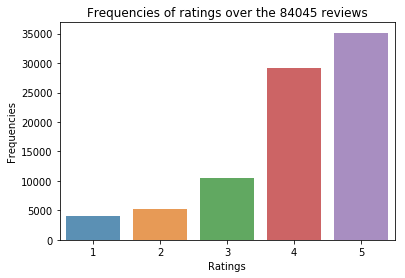

In [67]:
X_ratings = df.stars.value_counts()
ax = sns.barplot(X_ratings.index,X_ratings,alpha=0.8)
ax.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings over the {} reviews'.format(df.shape[0]))
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


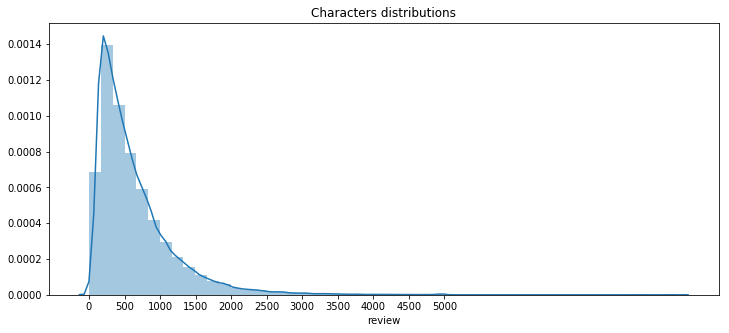

In [68]:
ax = plt.figure(figsize=(12,5))
sns.distplot(df['review'].apply(len))
plt.title('Characters distributions')
plt.xticks(range(0,5500,500))
plt.show()

Function to check language. We keep only the english reviews

In [69]:
df['isenglish'] = df['review'].progress_map(lambda x:langdetect.detect(x)=='en')
df = df[df['isenglish']==True].copy()
df.drop(['isenglish'],axis=1,inplace=True)

Checking the most frequent words in the corpus (except stop words)

In [70]:
stopW = stopwords.words('english')

allWords = []
for sent in df['review'].tolist():
    for word in sent.split():
        wordl=word.lower()
        if wordl not in stopW:
            allWords.append(wordl)
dist = nltk.FreqDist(allWords)

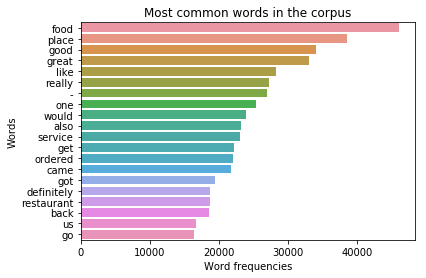

In [71]:
X = [nb[1] for nb in dist.most_common(20)]
y = [nb[0] for nb in dist.most_common(20)]
ax = sns.barplot(X,y)
ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
plt.show()

## Preprocessing
First, we lower the text.
Then, we remove:
- Stop Words
- words with a length less than 2 characters
- punctuation 
- more stopwords based on more frequent words we saw previously and that will not help us for topic extraction

We also use lemmatization on nouns, verbs and adjectives to get more consistent features and reduce the dimensionality of the future matrices

In [72]:
more_stopwords=['food','place','good','like','get','order','one','back','try','really','would','restaurant','come','also','make','love','great','n\'t','...','\'ve','\'re']
exclude = set(string.punctuation)
stopW = stopwords.words('english')
lemma = WordNetLemmatizer()

def preprocessing(sent):
    tokens = word_tokenize(sent)
    tokens = [w.lower() for w in tokens if w.lower() not in stopW]   
    tokens = [w for w in tokens if len(w)>2]
    tokens = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,pos='a'),pos='v'),pos='n') for w in tokens]
    tokens = [w for w in tokens if w not in exclude]
    tokens = [w for w in tokens if w not in more_stopwords]    
    return tokens

In [73]:
df['tokens'] = df['review'].progress_apply(preprocessing)

Let's save the DataFrame using pickle

In [87]:
with open('reviews_preprocessed.pickle', 'wb') as output:
    pickle.dump(df, output)

Let's add the bigrams too

In [85]:
tokens = df['tokens'].tolist()
bigram =  Phrases(tokens, min_count = 10)
bigram_mod = phrases.Phraser(bigram)
allTokens = list([bigram_mod[tokens]])
allTokens = [[t for t in token if t not in stopW] for token in allTokens]

Let's save the tokens and check the first few tokens

In [88]:
with open('allTokens.pickle', 'wb') as output:
    pickle.dump(allTokens, output)
allTokens[:10]

[[['junior',
   'since',
   'small',
   'child',
   'mom',
   'always',
   'breakfast',
   'time',
   'day',
   'though',
   'night',
   'specifically',
   'delicious',
   'cheesecake',
   'anytime',
   'downtown',
   'stop',
   'slice',
   'heaven',
   'even',
   'whole',
   'say',
   'think',
   'die',
   'go',
   'heaven..',
   'lol',
   'strawberry_cheesecake',
   'friendly',
   'people',
   'work'],
  ['initially',
   'hesitant',
   'huge',
   'diner',
   'everything',
   'wait',
   'staff_friendly',
   'drink',
   'string',
   'adventurous',
   'crave',
   'meat',
   'first_time',
   'go',
   'junior',
   'rib',
   'choice',
   'portion',
   'large',
   'leftover',
   'rib',
   'taste',
   'saucy',
   'bread',
   'serve',
   'entree',
   'something',
   'full',
   'reuben',
   'egg',
   'roll',
   "'ll"],
  ['**initial',
   'star',
   'review',
   'drop',
   'hope',
   'management',
   'fix',
   'increase',
   'star',
   'fire',
   'waiter',
   'system',
   'wide',
   'reason',
 